In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [19]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [20]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [21]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [22]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [23]:
from quantbullet.optimizer import LinearProductModelOLS

lpm_ols = LinearProductModelOLS()

In [24]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 1.0121
Iteration 2/10, MSE: 1.0122
Iteration 3/10, MSE: 1.0122
Iteration 4/10, MSE: 1.0122
Iteration 5/10, MSE: 1.0122
Iteration 6/10, MSE: 1.0122
Early stopping at iteration 6 with MSE: 1.0122


In [25]:
df['model_predict'] = lpm_ols.predict(train_df)

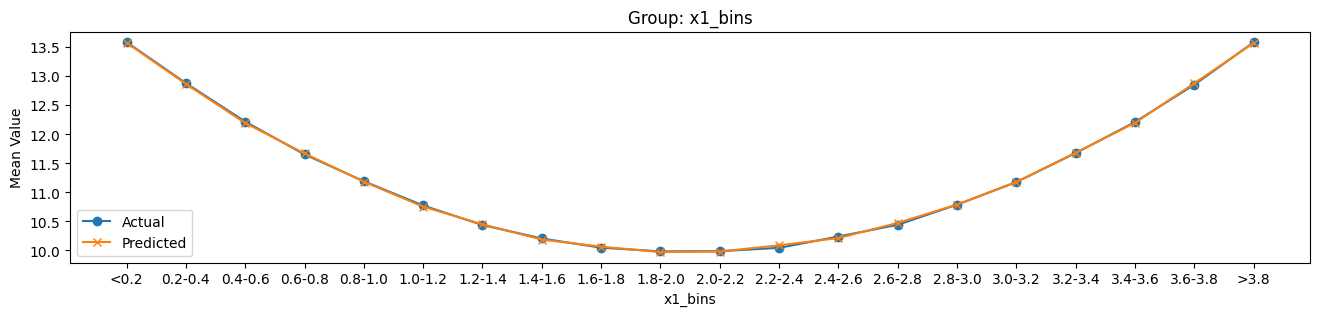

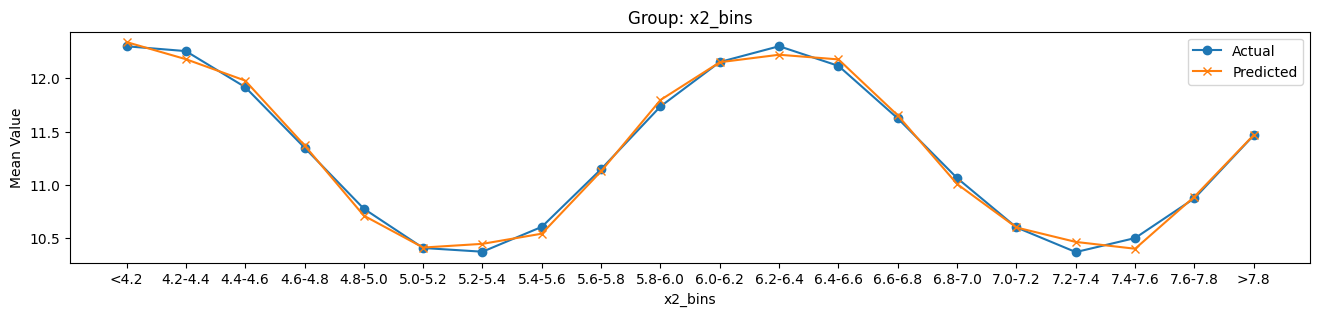

In [26]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Using Cross-Entropy Loss

In [100]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

np.float64(0.06899)

In [126]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-12, gtol=1e-12, eps=1e-3)

In [127]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00640192, 0.0030009 , 0.00580074, 0.00860017, 0.01140356,
       0.01420397, 0.01700261, 0.01980268, 0.02260297]), 'x2': array([0.00088407, 0.00395098, 0.00433789, 0.004725  , 0.00511184,
       0.00549862, 0.00588529, 0.006272  , 0.00665837])}
Iter 1: 24630.76719612181
Iter 2: 23708.117020937032
Iter 3: 22947.69744888009
Iter 4: 22773.021502525997
Iter 5: 22733.84517531262
Iter 6: 22701.247763801013
Iter 7: 22596.388134718054
Iter 8: 22457.461721218322
Iter 9: 22260.48356094119
Iter 10: 22033.25745012286
Iter 11: 21993.083635766096
Iter 12: 21991.545830583007
Iter 13: 21989.505757235933
Iter 14: 21985.927305321402
Iter 15: 21983.36868988613
Iter 16: 21970.849446674296
Iter 17: 21954.619802618487
Iter 18: 21925.777860472117
Iter 19: 21888.29151222217
Iter 20: 21840.96901002751
Iter 21: 21835.66527723631
Iter 22: 21835.14990776817
Iter 23: 21834.659027925896
Iter 24: 21834.012227560277
Iter 25: 21831.865933152134
Iter 26: 21827.706537893715
Iter 27:

In [128]:
lpc_scipy.coef_

array([-3.71123886e+00, -1.00687882e+00, -2.98884844e-01, -8.54650225e-02,
        1.73881303e-03, -8.59567349e-03,  1.02901453e-01,  2.57962777e-01,
        1.04556500e+00,  1.03382865e+00, -3.23989162e-01, -8.96239721e-01,
        8.24326785e-02,  7.89351009e-01,  1.73515989e-01, -9.24703185e-01,
       -1.46319838e-01,  8.37926993e-01])

In [129]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

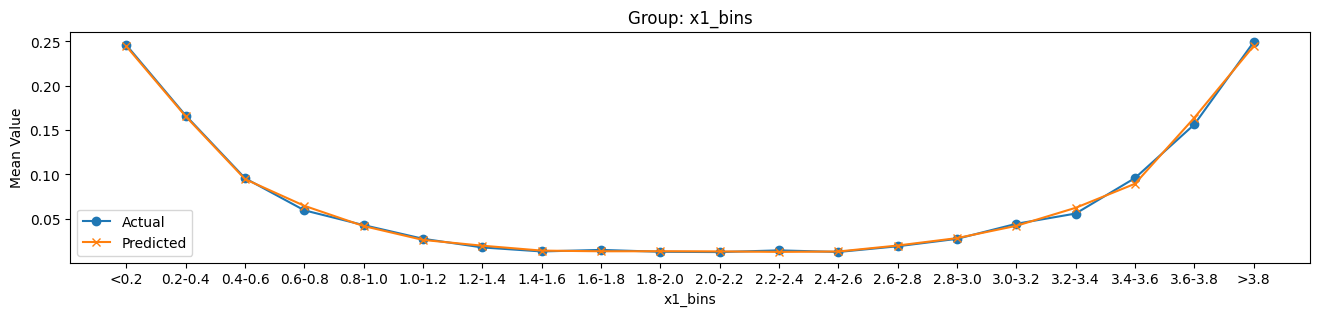

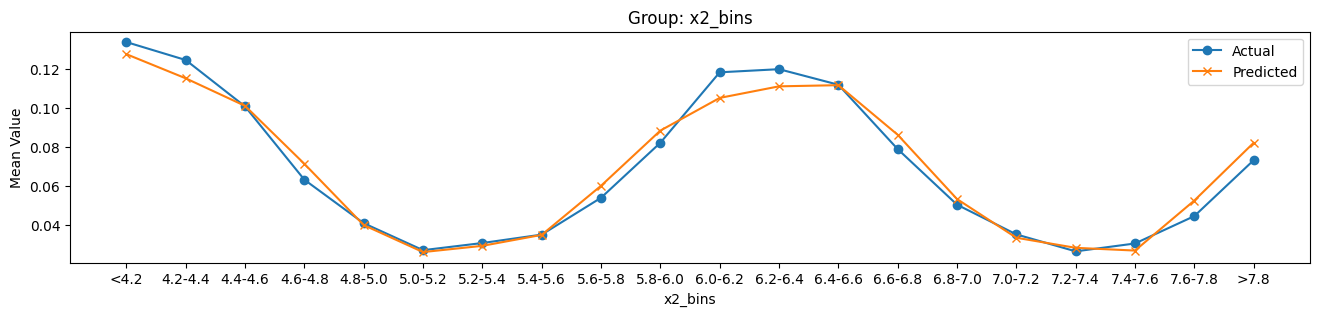

In [130]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Minimizing MSE, use OLS for Classification

In [89]:
probs = 1 / (1 + np.exp(-(df['y'] - 18)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.00504


In [90]:
from quantbullet.optimizer import LinearProductModelScipy, LinearProductModelOLS

lprm_ols = LinearProductModelOLS()

In [91]:
lprm_ols.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, MSE: 0.0049
Iteration 2/10, MSE: 0.2594
Iteration 3/10, MSE: 0.0054
Iteration 4/10, MSE: 0.0051
Iteration 5/10, MSE: 0.1620
Iteration 6/10, MSE: 0.0055
Iteration 7/10, MSE: 0.0052
Iteration 8/10, MSE: 0.0072
Iteration 9/10, MSE: 0.0050
Iteration 10/10, MSE: 0.0056


In [92]:
lprm_ols.coef_dict

{'x1': {'x1_bias': np.float64(-24.55391906051163),
  'x1_le_0.5': np.float64(-8.29489931638395),
  'x1_0.5_1.0': np.float64(-1.691799665969253),
  'x1_1.0_1.5': np.float64(-0.3334034022298519),
  'x1_1.5_2.0': np.float64(0.06991610935453896),
  'x1_2.0_2.5': np.float64(0.11513789682263623),
  'x1_2.5_3.0': np.float64(-0.060022569972122686),
  'x1_3.0_3.5': np.float64(1.7649659608819785),
  'x1_gt_3.5': np.float64(7.291257087024311)},
 'x2': {'x2_bias': np.float64(9.146138429871002),
  'x2_le_4.5': np.float64(0.006841168471403029),
  'x2_4.5_5.0': np.float64(-2.563294701590337),
  'x2_5.0_5.5': np.float64(-0.6015474640026418),
  'x2_5.5_6.0': np.float64(3.8054574204967935),
  'x2_6.0_6.5': np.float64(-0.21513333315495783),
  'x2_6.5_7.0': np.float64(-4.0174854804624465),
  'x2_7.0_7.5': np.float64(0.65329114369047),
  'x2_gt_7.5': np.float64(1.2029207522071679)}}

In [93]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

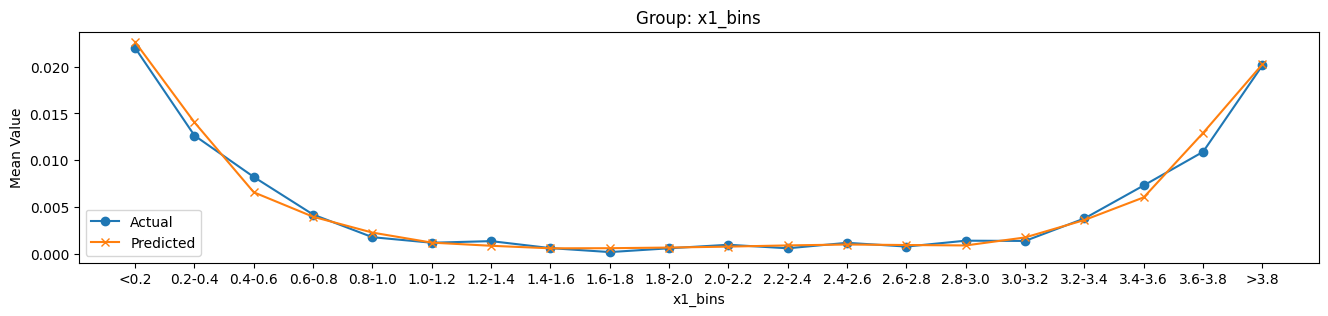

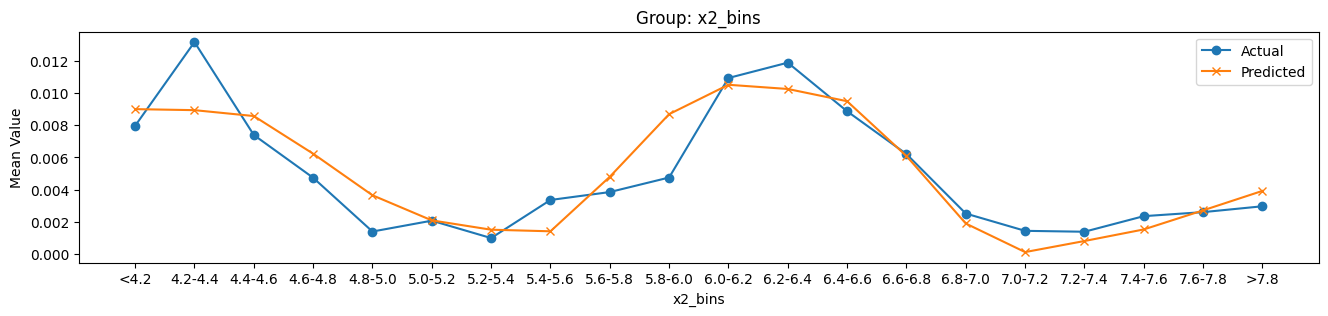

In [94]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [95]:
lpm_scipy = LinearProductModelScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpm_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4872e+10                                    1.44e+10    
       1              2         8.7000e+09      2.62e+10       4.24e+00       9.85e+09    
       2              4         5.4376e+08      8.16e+09       2.12e+00       1.23e+09    
       3              6         3.3988e+07      5.10e+08       1.06e+00       1.55e+08    
       4              8         2.1231e+06      3.19e+07       5.30e-01       1.98e+07    
       5             10         4.9708e+05      1.63e+06       2.65e-01       1.30e+07    
       6             12         3.4112e+02      4.97e+05       1.33e-01       1.80e+05    
       7             13         2.4859e+02      9.25e+01       2.65e-01       2.64e+03    
       8             14         2.4857e+02      1.52e-02       5.30e-01       2.78e+03    
       9             15         2.4854e+02      3.77e-02       5.30e-01       1.08e+03    

In [96]:
df['model_predict'] = lpm_scipy.predict(train_df)

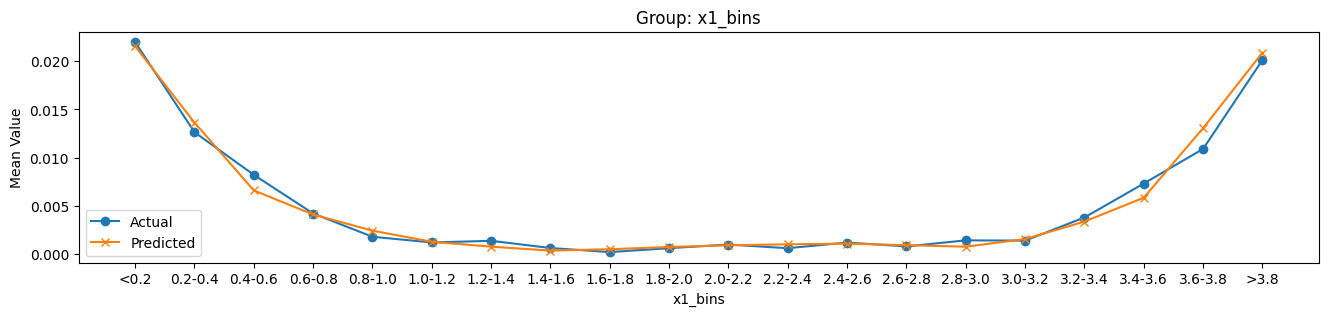

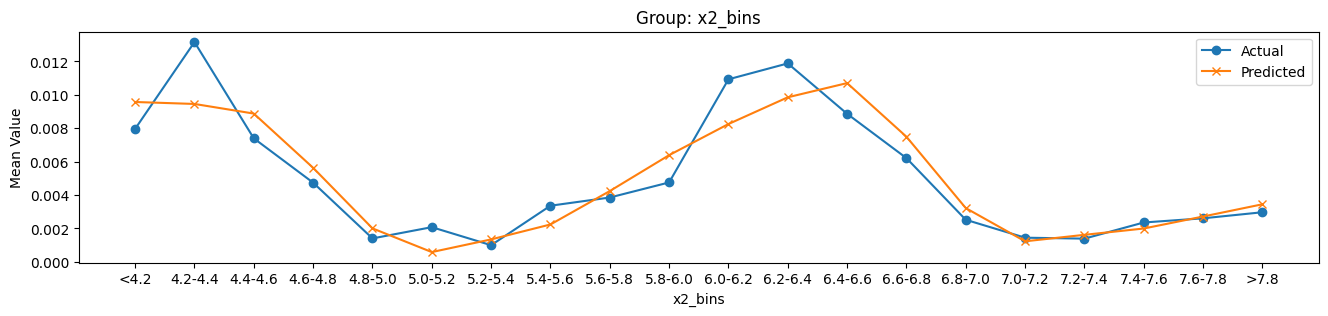

In [97]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [42]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0566
MSE (Scipy Optimization): 0.0564
